In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import wget 
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as smf
import math
import powerlaw

## Fetch data
Uncomment and run this cell to download the data used in the Wapman paper into the `data/` directory

In [2]:
#base = 'https://github.com/LarremoreLab/us-faculty-hiring-networks/raw/main/data/'
#file_names = ['edge-lists.csv', 'institution-stats.csv','stats.csv','yearly-stats.csv']
#for file in file_names:
#    if os.path.exists('data/'+file):
#        os.remove('data/'+file)
#    wget.download(base+file,out='data')

## Percentage of women over time by field
Use the summary stats in `data/yearly-stats.csv` to plot a graph comparing Math/Stats/OR to the
domain 'Math and Computing' and Academia as a whole

Text(0, 0.5, 'Fraction of Women')

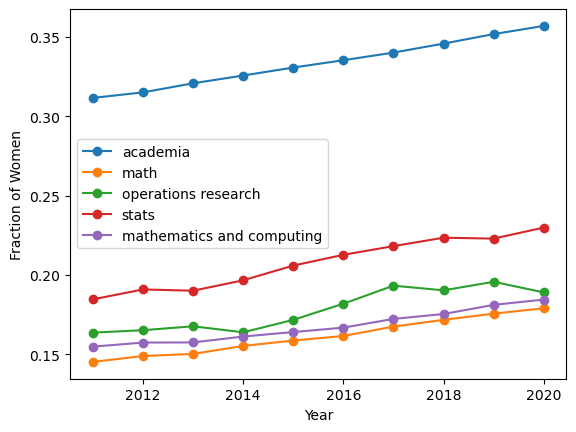

In [3]:
df = pd.read_csv('data/yearly-stats.csv')
df_academia = df[df['TaxonomyValue'] == 'Academia']
df_math = df[df['TaxonomyValue'] == 'Mathematics']
df_or = df[df['TaxonomyValue'] == 'Operations Research']
df_stats = df[df['TaxonomyValue'] == 'Statistics']
df_math_comp = df[df['TaxonomyValue'] == 'Mathematics and Computing']
plt.plot(df_academia['Year'], df_academia['FractionFemale'], 'o-', label='academia')
plt.plot(df_math['Year'], df_math['FractionFemale'],'o-', label='math')
plt.plot(df_or['Year'], df_or['FractionFemale'], 'o-', label='operations research')
plt.plot(df_stats['Year'], df_stats['FractionFemale'], 'o-', label='stats')
plt.plot(df_math_comp['Year'], df_math_comp['FractionFemale'], 'o-', label='mathematics and computing')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Fraction of Women')
#df

## Analysis by institution/department

In [4]:
df_edgesog = pd.read_csv('data/edge-lists.csv')
df_math_edges = df_edgesog[df_edgesog['TaxonomyValue'] == 'Mathematics'].copy()
df_math_stats_or_edges = df_edgesog[(df_edgesog['TaxonomyValue'] == 'Mathematics') |(df_edgesog['TaxonomyValue'] == 'Statistics') | (df_edgesog['TaxonomyValue'] == 'Operations Reseach')].copy()
df_stats_edges = df_edgesog[df_edgesog['TaxonomyValue'] == 'Statistics'].copy()
df_or_edges = df_edgesog[df_edgesog['TaxonomyValue'] == 'Operations Research'].copy()


#Actually I don't know why we are doing this
for df in [df_math_edges,df_math_stats_or_edges,df_stats_edges,df_or_edges]:
   df['Percentage of Women'] = df['Women']/(df['Men'] + df['Women'])*100 


Some descriptive statistics for the fields

In [5]:
print("There were " + str(int(df_math_edges['Men'].sum()+df_math_edges['Women'].sum())) + " people in the math sample")
print(str(round(df_math_edges['Women'].sum()/(df_math_edges['Men'].sum()+df_math_edges['Women'].sum())*100,1)) + "% were women")

print("There were " + str(int(df_stats_edges['Men'].sum()+df_stats_edges['Women'].sum())) + " people in the stats sample")
print(str(round(df_stats_edges['Women'].sum()/(df_stats_edges['Men'].sum()+df_stats_edges['Women'].sum())*100,1)) + "% were women")

print("There were " + str(int(df_or_edges['Men'].sum()+df_or_edges['Women'].sum())) + " people in the OR sample")
print(str(round(df_or_edges['Women'].sum()/(df_or_edges['Men'].sum()+df_or_edges['Women'].sum())*100,1)) + "% were women")

print("There were " + str(int(df_math_stats_or_edges['Men'].sum()+df_math_stats_or_edges['Women'].sum())) + " people in the combined sample")
print(str(round(df_math_stats_or_edges['Women'].sum()/(df_math_stats_or_edges['Men'].sum()+df_math_stats_or_edges['Women'].sum())*100,1)) + "% were women")

There were 7238 people in the math sample
16.8% were women
There were 2576 people in the stats sample
20.9% were women
There were 1034 people in the OR sample
19.3% were women
There were 9814 people in the combined sample
17.9% were women


In [6]:
def OverallInstitutionCount(df):
    df_data_by_institution = pd.concat([df.groupby('InstitutionName')['Men'].sum(), df.groupby('InstitutionName')['Women'].sum()],axis=1)
    df_data_by_institution['Percentage of Women'] = df_data_by_institution['Women']/(df_data_by_institution['Men']+df_data_by_institution['Women'])*100
    return df_data_by_institution.reset_index()

df_data_by_institution_math = OverallInstitutionCount(df_math_edges)
df_data_by_institution_msor = OverallInstitutionCount(df_math_stats_or_edges)
df_data_by_institution_stats = OverallInstitutionCount(df_stats_edges)
df_data_by_institution_or = OverallInstitutionCount(df_or_edges)

df_data_by_institution_math

,InstitutionName,Men,Women,Percentage of Women
0,Air Force Institute of Technology,30.0,5.0,14.285714
1,American,13.0,7.0,35.000000
2,Arizona State,79.0,28.0,26.168224
3,Auburn,43.0,4.0,8.510638
4,Ball State,18.0,9.0,33.333333
...,...,...,...,...
218,Western Michigan,19.0,9.0,32.142857
219,Wichita State,25.0,3.0,10.714286
220,William & Mary,13.0,2.0,13.333333
221,Worcester Polytechnic Institute,34.0,6.0,15.000000


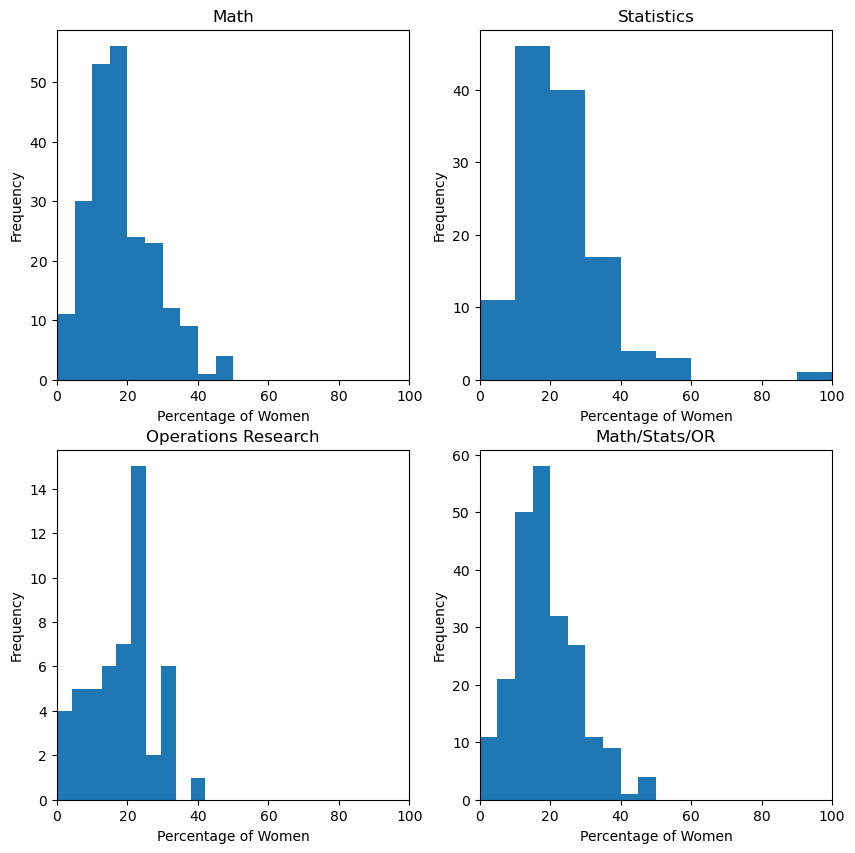

In [7]:
#Plot some histograms by field
plt.figure(figsize=(10,10))
for (i,(df, title)) in enumerate([(df_data_by_institution_math,"Math"),(df_data_by_institution_stats,"Statistics"),
                              (df_data_by_institution_or, "Operations Research"),(df_data_by_institution_msor, "Math/Stats/OR")]):
    plt.subplot(2,2,i+1)
    plt.xlim([0,100])
    plt.hist(df['Percentage of Women'],bins=10)
    plt.title(title)
    plt.xlabel('Percentage of Women')
    plt.ylabel('Frequency')


## Incorporate prestige

In [8]:
df_prestige_og = pd.read_csv('data/institution-stats.csv')
df_prestige_math = df_prestige_og[df_prestige_og['TaxonomyValue'] == 'Mathematics'].copy()
df_prestige_msor = df_prestige_og[(df_prestige_og['TaxonomyValue'] == 'Mathematics') |(df_prestige_og['TaxonomyValue'] == 'Statistics') | (df_prestige_og['TaxonomyValue'] == 'Operations Reseach')].copy()
df_prestige_stats = df_prestige_og[df_prestige_og['TaxonomyValue'] == 'Statistics'].copy()
df_prestige_or = df_prestige_og[df_prestige_og['TaxonomyValue'] == 'Operations Research'].copy()

Some institutions have demographic data, but no prestige data

In [9]:
print(np.setdiff1d(df_data_by_institution_math['InstitutionName'], df_prestige_math['InstitutionName']))
#print(np.setdiff1d(df_data_by_institution_msor['InstitutionName'], df_prestige_msor['InstitutionName']))

['American' 'Ball State' 'Bard College' 'Barry' 'Brigham Young'
 'Bryn Mawr' 'Claremont Graduate' 'Cleveland State' 'Drew' 'Drexel'
 'East Carolina' 'Florida A&M' 'Florida Atlantic'
 'Florida Institute of Technology' 'Florida International' 'Fordham'
 'George Mason' 'Georgetown' 'IUPUI' 'Miami University'
 'Michigan Technological' 'New Jersey Institute of Technology'
 'New Mexico Tech' 'North Dakota State' 'Northern Arizona'
 'Oakland University' 'Rutgers University - Camden' 'San Diego State'
 'South Dakota Mines' 'South Dakota State'
 'Southern Illinois University Carbondale' 'Texas A&M Corpus Christi'
 'Texas A&M Kingsville' 'UC Merced' 'UMass Boston' 'UMass Dartmouth'
 'UMass Lowell' 'UNC Charlotte' 'UNC Greensboro' 'UT Dallas' 'UT El Paso'
 'UT San Antonio' 'UT Tyler' 'University of Alaska Fairbanks'
 'University of Dayton' 'University of Denver'
 'University of Louisiana Monroe' 'University of Louisville'
 'University of Maine' 'University of Maryland Baltimore County'
 'Universi

In [10]:
fields = ['Mathematics', 'Statistics', 'Operations Research']
combined_df = dict()
for field in fields:
    combined_df[field] = OverallInstitutionCount(df_edgesog[df_edgesog['TaxonomyValue'] == field].copy()).merge(df_prestige_og[df_prestige_og['TaxonomyValue'] == field].copy(),on='InstitutionName')
    combined_df[field] = combined_df[field].sort_values(by=['OrdinalPrestigeRank']).reset_index(drop=True)
    combined_df[field] = combined_df[field].reset_index().rename(columns={'index' : 'Rescaled Rank' })

combined_df['Mathematics']

,Rescaled Rank,InstitutionName,Men,Women,Percentage of Women,InstitutionId,TaxonomyLevel,TaxonomyValue,NonAttritionEvents,AttritionEvents,ProductionRank,PrestigeRank,OrdinalPrestigeRank
0,0,Harvard,16.0,3.0,15.789474,87.0,Field,Mathematics,214.0,56.0,3,1.000000,0
1,1,Princeton,54.0,3.0,5.263158,167.0,Field,Mathematics,301.0,85.0,1,0.997586,1
2,2,University of Chicago,34.0,4.0,10.526316,261.0,Field,Mathematics,211.0,54.0,4,0.915439,2
3,3,MIT,58.0,7.0,10.769231,123.0,Field,Mathematics,280.0,73.0,2,0.914986,3
4,4,UC Berkeley,56.0,7.0,11.111111,251.0,Field,Mathematics,381.0,106.0,0,0.901592,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,156,University of Southern Mississippi,9.0,5.0,35.714286,336.0,Field,Mathematics,2.0,1.0,168,0.100969,205
157,157,Mississippi State,16.0,6.0,27.272727,136.0,Field,Mathematics,2.0,1.0,180,0.091462,207
158,158,University of Tulsa,21.0,3.0,12.500000,342.0,Field,Mathematics,4.0,1.0,149,0.087167,209
159,159,University of North Dakota,12.0,2.0,14.285714,319.0,Field,Mathematics,2.0,1.0,167,0.079871,212


We are going to define "Elite" as the top 25%, taking a cue from how AMS used to define Group I institutions

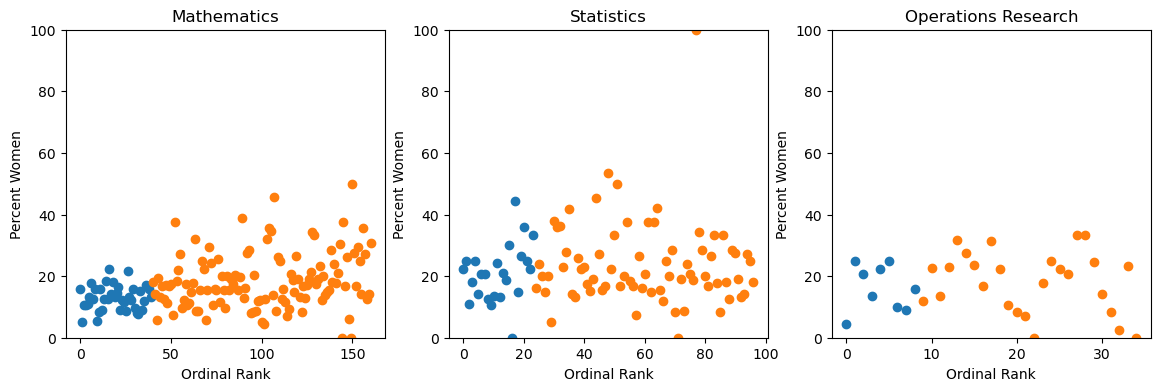

In [11]:
elite_df = dict()
non_elite_df = dict()
for field in fields:
    elite_df[field] = combined_df[field][combined_df[field]['Rescaled Rank'] < np.quantile(combined_df[field]['Rescaled Rank'],.25)]
    non_elite_df[field] = combined_df[field][combined_df[field]['Rescaled Rank'] >= np.quantile(combined_df[field]['Rescaled Rank'],.25)]


plt.figure(figsize=(14,4))
for (i,field) in enumerate(fields):
    plt.subplot(1,3,i+1)
    plt.scatter(elite_df[field]['Rescaled Rank'], elite_df[field]["Percentage of Women"])
    plt.scatter(non_elite_df[field]['Rescaled Rank'], non_elite_df[field]["Percentage of Women"])
    plt.xlabel('Ordinal Rank')
    plt.ylabel('Percent Women')
    plt.ylim(0,100)
    plt.title(field)

In [12]:
#Who is that Stats outlier at 100%???
combined_df['Statistics'].sort_values(by=['Percentage of Women'])

,Rescaled Rank,InstitutionName,Men,Women,Percentage of Women,InstitutionId,TaxonomyLevel,TaxonomyValue,NonAttritionEvents,AttritionEvents,ProductionRank,PrestigeRank,OrdinalPrestigeRank
16,16,University of Illinois Urbana-Champaign,12.0,0.0,0.000000,280.0,Field,Statistics,55.0,19.0,13,0.699292,16
71,71,LSU,9.0,0.0,0.000000,109.0,Field,Statistics,6.0,2.0,78,0.298500,72
29,29,Rutgers - New Brunswick,18.0,1.0,5.263158,177.0,Field,Statistics,25.0,5.0,35,0.587433,29
57,57,Northeastern,38.0,3.0,7.317073,150.0,Field,Statistics,3.0,2.0,114,0.410291,57
70,70,University of Maryland Baltimore County,22.0,2.0,8.333333,288.0,Field,Statistics,4.0,1.0,103,0.324286,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,17,Northwestern,5.0,4.0,44.444444,153.0,Field,Statistics,24.0,8.0,37,0.656237,17
44,44,University of Georgia,6.0,5.0,45.454545,274.0,Field,Statistics,22.0,6.0,42,0.491699,44
51,51,Oklahoma State,3.0,3.0,50.000000,158.0,Field,Statistics,12.0,2.0,65,0.431267,51
48,48,Oregon State,7.0,8.0,53.333333,161.0,Field,Statistics,9.0,4.0,75,0.456943,48


In [13]:
#MATH
#In which we attempt some stats

for field in fields:
    #default is two_sided
    print("\n")
    print(field+"\n\n")
    print("Two sided t-test")
    print(stats.ttest_ind(elite_df[field]['Percentage of Women'], non_elite_df[field]['Percentage of Women']))
    print("One sided t-test")
    print(stats.ttest_ind(elite_df[field]['Percentage of Women'], non_elite_df[field]['Percentage of Women'], alternative = 'less'))

    print("\nElite Mean/SD/Max")
    print(np.mean(elite_df[field]['Percentage of Women']))
    print(np.std(elite_df[field]['Percentage of Women']))
    print(np.max(elite_df[field]['Percentage of Women']))

    print("\nNon Elite Mean/SD/Max")
    print(np.mean(non_elite_df[field]['Percentage of Women']))
    print(np.std(non_elite_df[field]['Percentage of Women']))
    print(np.max(non_elite_df[field]['Percentage of Women']))

#ITS SIGNIFICANT AND (SLIGHTLY LESS BUT ALSO STILL PRETTY) DEPRESSING



Mathematics


Two sided t-test
Ttest_indResult(statistic=-3.716721991777491, pvalue=0.000279162281145512)
One sided t-test
Ttest_indResult(statistic=-3.716721991777491, pvalue=0.000139581140572756)

Elite Mean/SD/Max
13.056037433226498
3.943824175878575
22.22222222222222

Non Elite Mean/SD/Max
18.554576086504657
9.017558275523273
50.0


Statistics


Two sided t-test
Ttest_indResult(statistic=-0.9905764495642845, pvalue=0.3244087791317215)
One sided t-test
Ttest_indResult(statistic=-0.9905764495642845, pvalue=0.16220438956586075)

Elite Mean/SD/Max
21.00757856741296
9.201282685340816
44.44444444444444

Non Elite Mean/SD/Max
24.005606449981105
13.692061202323346
100.0


Operations Research


Two sided t-test
Ttest_indResult(statistic=-0.5758430587787192, pvalue=0.5686278354944445)
One sided t-test
Ttest_indResult(statistic=-0.5758430587787192, pvalue=0.28431391774722226)

Elite Mean/SD/Max
16.194423150047506
7.0126618371730025
25.0

Non Elite Mean/SD/Max
18.290264132297388
9.7665210352

Actually I don't think the above is what we want to do. I think we want to add up all the people hired in the elite group, rather
than departments

In [14]:
for field in fields:
    print(field)
    print("Elite percentage of women: " + str( elite_df[field]['Women'].sum() / (elite_df[field]['Men'].sum() + elite_df[field]['Women'].sum() ) ) )
    print("Nonelite percentage of women: " + str( non_elite_df[field]['Women'].sum() / (non_elite_df[field]['Men'].sum() + non_elite_df[field]['Women'].sum() ) ) )
    print(stats.chi2_contingency([[elite_df[field]['Men'].sum(),elite_df[field]['Women'].sum()],
                                  [non_elite_df[field]['Men'].sum(),non_elite_df[field]['Women'].sum()]]) )

Mathematics
Elite percentage of women: 0.12506680919294494
Nonelite percentage of women: 0.1813761244833455
Chi2ContingencyResult(statistic=29.364526008352886, pvalue=5.996533556144964e-08, dof=1, expected_freq=array([[1564.58622995,  306.41377005],
       [3439.41377005,  673.58622995]]))
Statistics
Elite percentage of women: 0.21303258145363407
Nonelite percentage of women: 0.21581450653983353
Chi2ContingencyResult(statistic=0.002895307598697841, pvalue=0.9570880858170816, dof=1, expected_freq=array([[ 313.10283518,   85.89716482],
       [1319.89716482,  362.10283518]]))
Operations Research
Elite percentage of women: 0.17040358744394618
Nonelite percentage of women: 0.18696397941680962
Chi2ContingencyResult(statistic=0.1959904779636031, pvalue=0.6579768696646997, dof=1, expected_freq=array([[182.32878412,  40.67121588],
       [476.67121588, 106.32878412]]))


## Incorporating funding data

In [15]:
nsf_df = pd.read_csv("data/NSF DMS Awards.csv")
nsf_df['AwardedAmountToDate'] = nsf_df['AwardedAmountToDate'].apply(lambda x: x.replace('$','').replace(',','').replace('.00','')).astype(int)
print("The total amount awarded by NSF per year was $" + str(int(round(nsf_df['AwardedAmountToDate'].sum()/10,-6)/1000000))+"M")
#Quick check for duplicate award numbers
print(nsf_df['AwardNumber'].duplicated().value_counts())

nsf_institution = nsf_df.groupby('Organization')['AwardedAmountToDate'].sum()
#nsf_institution.sort_values(ascending=False)
nsf_frame = nsf_institution.to_frame().reset_index()
merged_df = combined_df['Mathematics'].merge(nsf_institution.to_frame(), left_on = 'InstitutionName',right_on='Organization',how='left')

#This merge didn't go great since the dataset and the NSF have variance in institution names...
print(np.setdiff1d(combined_df['Mathematics']['InstitutionName'], nsf_frame['Organization']).size)
print(np.setdiff1d(combined_df['Mathematics']['InstitutionName'], nsf_frame['Organization']))

#Produce file names.txt with data set institution names
with open("intermediate files/names.txt", "w") as txt_file:
    for line in np.setdiff1d(combined_df['Mathematics']['InstitutionName'], nsf_frame['Organization']):
        txt_file.write(line + "\n")

#Produce NSF_namees.txt with NSF institution names
array=nsf_frame['Organization'].astype(str).sort_values().values
with open("intermediate files/NSF_names.txt", "w") as txt_file:
    for line in array:
        txt_file.write(line + "\n")

The total amount awarded by NSF per year was $235M
False    10023
Name: AwardNumber, dtype: int64
123
['Air Force Institute of Technology' 'Arizona State' 'Auburn' 'Baylor'
 'Boston University' 'Bowling Green State' 'Brandeis' 'Brown' 'CU Boulder'
 'CU Denver' 'Caltech' 'Carnegie Mellon' 'Case Western Reserve'
 'Central Michigan' 'Clarkson' 'Clemson' 'Colorado State' 'Columbia'
 'Cornell' 'Dartmouth' 'Duke' 'Emory' 'Florida State' 'George Washington'
 'Georgia State' 'Georgia Tech' 'Harvard' 'Howard' 'Illinois State'
 'Indiana University Bloomington' 'Iowa State' 'Johns Hopkins'
 'Kansas State' 'Kent State' 'LSU' 'Lehigh' 'Louisiana Tech'
 'Loyola University Chicago' 'MIT' 'Marquette' 'Michigan State'
 'Mississippi State' 'Missouri S&T' 'Montana State' 'NYU'
 'New Mexico State' 'North Carolina State' 'Northeastern'
 'Northern Illinois' 'Northwestern' 'Oklahoma State' 'Old Dominion'
 'Oregon State' 'Penn State' 'Portland State' 'Princeton' 'Purdue' 'Rice'
 'Rutgers - New Brunswick' 'Rut

Manually, we created the file Institution Names.csv, which has an NSF institution name matched to each institution name from the dataset

In [16]:
name_map = pd.read_csv("intermediate files/Insitution Names.csv")
name_map

,Wapman name,NSF name
0,Air Force Institute of Technology,NaN
1,Arizona State,Arizona State University
2,Auburn,Auburn University
3,Baylor,Baylor University
4,Boston University,Trustees of Boston University
...,...,...
118,Washington University St. Louis,Washington University
119,Wayne State,Wayne State University
120,Wesleyan,Wesleyan University
121,Western Michigan,Western Michigan University


Text(0, 0.5, 'NSF DMS Average Annual Funds Awarded in Millions')

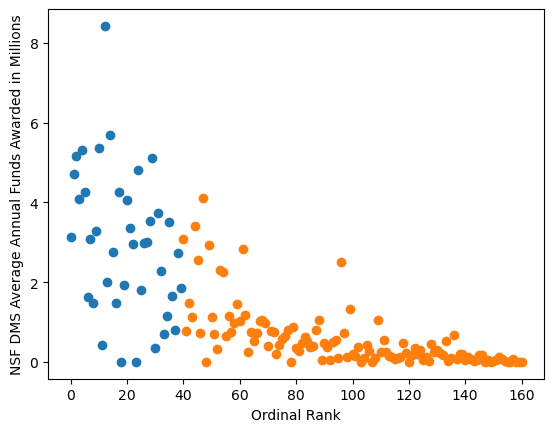

In [17]:
merged_df2 = merged_df.merge(name_map, left_on = 'InstitutionName',right_on='Wapman name',how='left')
merged_df3 = merged_df2.merge(nsf_institution,left_on= 'NSF name', right_on = 'Organization',how='left')
merged_df3['AwardedAmount']=merged_df3['AwardedAmountToDate_x'].fillna(0)+merged_df3['AwardedAmountToDate_y'].fillna(0)
df_merged_final = merged_df3[['InstitutionName','Percentage of Women','Rescaled Rank','AwardedAmount']]

elite = df_merged_final[df_merged_final['Rescaled Rank'] < np.quantile(df_merged_final['Rescaled Rank'],.25)]
non_elite = df_merged_final[df_merged_final['Rescaled Rank'] >= np.quantile(df_merged_final['Rescaled Rank'],.25)]
plt.scatter(elite['Rescaled Rank'], elite["AwardedAmount"]/10000000)
plt.scatter(non_elite['Rescaled Rank'], non_elite["AwardedAmount"]/10000000)
plt.xlabel('Ordinal Rank')
plt.ylabel('NSF DMS Average Annual Funds Awarded in Millions')

In [18]:
print("Elite institutions hoarded $" + str(int(round(elite['AwardedAmount'].sum()/10,-6)/1000000)) + "M of NSF money per year")
print("Non-Elite institutions, of which there are three times as many, were awarded only $" + str(int(round(non_elite['AwardedAmount'].sum()/10,-6)/1000000)) + "M of NSF money per year")

Elite institutions hoarded $119M of NSF money per year
Non-Elite institutions, of which there are three times as many, were awarded only $70M of NSF money per year


Text(0, 0.5, 'NSF DMS Average Annual Funds Awarded in Millions')

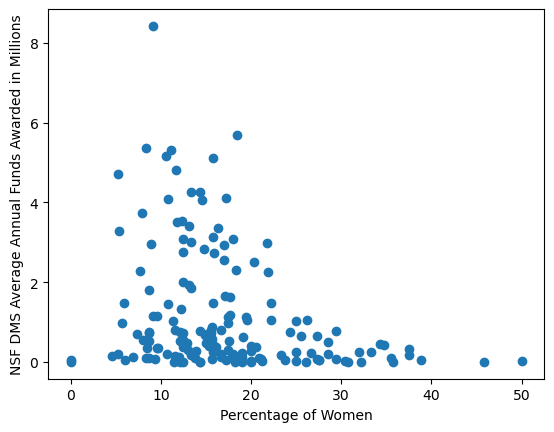

In [19]:
plt.scatter(df_merged_final['Percentage of Women'], df_merged_final["AwardedAmount"]/10000000)
plt.xlabel('Percentage of Women')
plt.ylabel('NSF DMS Average Annual Funds Awarded in Millions')

## Rich get Richer?
If we treat this as a rank and resources, lets see if the Pareto distribution/power law holds

In [20]:
#cumuluative scatterplot needs cumulative data
# how much did each group accumulate
eliteNSF_sum = sum(elite['AwardedAmount'])
print(eliteNSF_sum)
non_eliteNSF_sum = sum(non_elite['AwardedAmount'])
print(non_eliteNSF_sum)

1189621229.0
696884223.0


In [21]:
#make a new df with just the cumulative amounts
NSFcumsum_df = elite.loc[:, ['Rescaled Rank','AwardedAmount']]
#print(NSFcumsum_df.info)
neaward_df = non_elite.loc[:, ['Rescaled Rank','AwardedAmount']]
#print(neaward_df.info)
NSFcumsum_df = NSFcumsum_df.append(neaward_df)
#NSFcumsum_df.info

#cumulative column scaled to millions
NSFcumsum_df['Cumulative Award'] = NSFcumsum_df['AwardedAmount'].cumsum()/1000000
NSFcumsum_df.info

C:\Users\cdeaton\AppData\Local\Temp\ipykernel_18224\1924914029.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NSFcumsum_df = NSFcumsum_df.append(neaward_df)


<bound method DataFrame.info of      Rescaled Rank  AwardedAmount  Cumulative Award
0                0     31238184.0         31.238184
1                1     47213787.0         78.451971
2                2     51632352.0        130.084323
3                3     40922061.0        171.006384
4                4     53189368.0        224.195752
..             ...            ...               ...
156            156            0.0       1885.895485
157            157       609967.0       1886.505452
158            158            0.0       1886.505452
159            159            0.0       1886.505452
160            160            0.0       1886.505452

[161 rows x 3 columns]>

In [22]:
# fit power distribution
# log-log transformation needed, but you cannot do that if you have 0 rank
# so we start rank at 1
NSFcumsum_df["Rescaled Rank"] += 1
#NSFcumsum_df.info

# log log both axes
NSFcumsum_df["Log(Rank)"] = np.log(NSFcumsum_df["Rescaled Rank"])
NSFcumsum_df["Log(CumSum)"] = np.log(NSFcumsum_df["Cumulative Award"])
NSFcumsum_df.info

<bound method DataFrame.info of      Rescaled Rank  AwardedAmount  Cumulative Award  Log(Rank)  Log(CumSum)
0                1     31238184.0         31.238184   0.000000     3.441641
1                2     47213787.0         78.451971   0.693147     4.362487
2                3     51632352.0        130.084323   1.098612     4.868183
3                4     40922061.0        171.006384   1.386294     5.141701
4                5     53189368.0        224.195752   1.609438     5.412520
..             ...            ...               ...        ...          ...
156            157            0.0       1885.895485   5.056246     7.542158
157            158       609967.0       1886.505452   5.062595     7.542481
158            159            0.0       1886.505452   5.068904     7.542481
159            160            0.0       1886.505452   5.075174     7.542481
160            161            0.0       1886.505452   5.081404     7.542481

[161 rows x 5 columns]>

(-2.2276802235224, 0.0259018467205274)


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


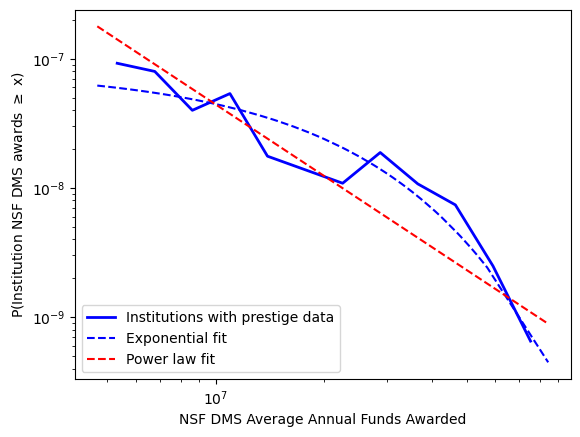

In [45]:
#total awarded over 10 years (at least of the subset considered)
total_NSF = NSFcumsum_df.loc[160,"Cumulative Award"]
pldata = NSFcumsum_df['AwardedAmount']#/total_NSF I did not normalize amounts here

#powerlaw fit
fit=powerlaw.Fit(pldata)
Rp = fit.distribution_compare('power_law','exponential',normalized_ratio=True)
print(Rp)

#powerlaw visualize
fig2=fit.plot_pdf(color='b',linewidth=2, label = 'Institutions with prestige data')
fit.exponential.plot_pdf(color='b',linestyle='--',ax=fig2, label = 'Exponential fit')
fit.power_law.plot_pdf(color='r',linestyle='--',ax=fig2, label = 'Power law fit')
plt.xlabel('NSF DMS Average Annual Funds Awarded')
plt.ylabel('P(Institution NSF DMS awards $\geq$ x)')
plt.legend(loc='lower left')

In [25]:
#of the 235 million per year that NSF DMS gives
#elite institutions
top_n = 41
sumof_elite = NSFcumsum_df.loc[top_n-1,"Cumulative Award"]
print("The total NSF DMS awarded over 10 years to elite institutions is $", str(round(sumof_elite,2)), "million")

print("The total NSF DMS awarded over 10 years is $", str(round(total_NSF)), "million")

#elite institution %
elite_per = 100*41/161
print("Elite universities represent %", str(round(elite_per,2)), "%", "of our dataset")

#% elite institutions have
elite_NSFper = 100*sumof_elite/total_NSF
print("NSF DMS awarded", str(round(elite_NSFper,2)), "%" ,"of the funds in our dataset to these elite universities")

The total NSF DMS awarded over 10 years to elite institutions is $ 1220.48 million
The total NSF DMS awarded over 10 years is $ 1887 million
Elite universities represent % 25.47 % of our dataset
NSF DMS awarded 64.7 % of the funds in our dataset to these elite universities


In [26]:
#of the 235 million per year that NSF DMS gives
#top n institutions
top_n = 5
sumoftop_n = NSFcumsum_df.loc[top_n-1,"Cumulative Award"]
print("The total NSF DMS awarded over 10 years to the top", str(top_n),"institutions is $", str(round(sumoftop_n,2)), "million")

#total awarded over 10 years (at least of the subset considered)
total_NSF = NSFcumsum_df.loc[160,"Cumulative Award"]
print("The total NSF DMS awarded over 10 years is $", str(round(total_NSF)), "million")

#elite institution %
topn_per = 100*top_n/161
print("The top", str(top_n),"universities represent %", str(round(topn_per,2)), "%", "of our dataset")

#% elite institutions have
topn_NSFper = 100*sumoftop_n/total_NSF
print("NSF DMS awarded", str(round(topn_NSFper,2)), "%" ,"of the funds in our dataset to these", str(top_n),"universities")

The total NSF DMS awarded over 10 years to the top 5 institutions is $ 224.2 million
The total NSF DMS awarded over 10 years is $ 1887 million
The top 5 universities represent % 3.11 % of our dataset
NSF DMS awarded 11.88 % of the funds in our dataset to these 5 universities


In [27]:
#of the 235 million per year that NSF DMS gives
#what do the top n% get
top_nper = 30 # %
top_n = math.ceil(top_nper*161/100) # convert to n
#print(top_n)
sumoftop_n = NSFcumsum_df.loc[top_n-1,"Cumulative Award"] 
print("The total NSF DMS awarded over 10 years to the top",str(top_nper),"%","institutions is $", str(round(sumoftop_n,2)), "million")

#total awarded over 10 years (at least of the subset considered)
#total_NSF = NSFcumsum_df.loc[160,"Cumulative Award"]
#print("The total NSF DMS awarded over 10 years is $", str(round(total_NSF)), "million")

#% the top n per have
top_NSFper = 100*sumoftop_n/total_NSF
print("NSF DMS awarded", str(round(top_NSFper,2)), "%" ,"of the funds to these institutions in our dataset")

The total NSF DMS awarded over 10 years to the top 30 % institutions is $ 1362.1 million
NSF DMS awarded 72.2 % of the funds to these institutions in our dataset


In [28]:
#The amount of every award DMS awarded - not just our subset
#divide by 10 makes it an average per year
nsf_institution = nsf_df[nsf_df['AwardInstrument']!='Fellowship Award'].groupby('Organization')['AwardedAmountToDate'].sum()/10
nsf_frame = nsf_institution.to_frame().reset_index()

#just the award amounts
alldata = nsf_frame['AwardedAmountToDate'].copy()
alldata.info

<bound method Series.info of 0          397.6
1        44276.5
2         2640.0
3         3000.0
4      3307584.3
         ...    
459     482600.0
460      18991.4
461    1623953.0
462     123359.2
463       6200.0
Name: AwardedAmountToDate, Length: 464, dtype: float64>

Calculating best minimal value for power law fit


(5.806435972228003, 6.38166605087333e-09)
(-4.051499098876309, 5.089052217456769e-05)
(-4.051499098876309, 5.089052217456769e-05)
(4.660221033870846, 3.1586999881622927e-06)


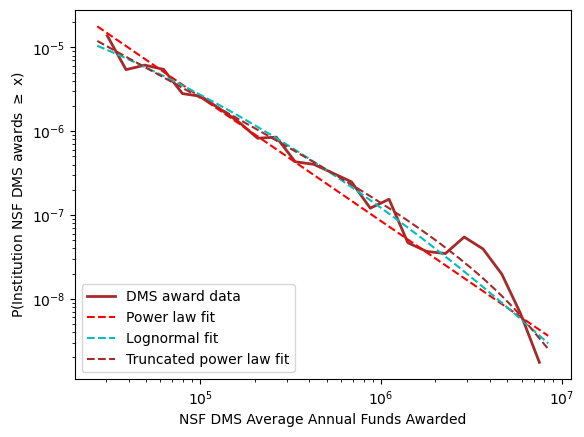

In [50]:

#powerlaw fit
fit_all=powerlaw.Fit(alldata)
Rp_all = fit_all.distribution_compare('power_law','exponential',normalized_ratio=True)
print(Rp_all)
Rp_all2 = fit_all.distribution_compare('power_law','lognormal',normalized_ratio=True)
print(Rp_all2)
Rp_all3 = fit_all.distribution_compare('power_law','lognormal_positive',normalized_ratio=True)
print(Rp_all3)
Rp_all4 = fit_all.distribution_compare('truncated_power_law','lognormal',normalized_ratio=True)
print(Rp_all4)

#powerlaw visualize
fig_all=fit_all.plot_pdf(color='brown',linewidth=2, label = 'DMS award data')
#exponential is such a bad fit it throws the scale off
#fit_all.exponential.plot_pdf(color='r',linestyle='--',ax=fig_all, label ='Exponential fit')
fit_all.power_law.plot_pdf(color='r',linestyle='--',ax=fig_all, label ='Power law fit')
fit_all.lognormal.plot_pdf(color='c',linestyle='--',ax=fig_all, label ='Lognormal fit')
fit_all.truncated_power_law.plot_pdf(color='brown',linestyle='--',ax=fig_all, label ='Truncated power law fit')
plt.xlabel('NSF DMS Average Annual Funds Awarded')
plt.ylabel('P(Institution NSF DMS awards $\geq$ x)')
plt.legend(loc='lower left')


The results of multiple fit comparison tests suggest Lognormal or, more likely, a truncated power law. The lognormal results where there are random multiplicative factors at play. One of those could certainly be eliteness, resourcing to write and execute proposals, hiring of individuals with proven track records of funding and more. However, we argue that these are not independent. The truncated power law as an alternative (p-value < .001) makes sense. Power law is the result of preferential attachement, whereas truncated power law also requires some mechanism of selection or trimming. Since we are looking at NSF awards, it makes sense that there would be some selection.

In [30]:
#of the 235 million per year that NSF DMS gives
#what do the top n% get
top_nper = 20 # %
top_n = math.ceil(top_nper*464/100) # convert to n
print(top_n)
#print(top_n)

#total
total_NSF = alldata.sum()

#topn
top_n_result= alldata.nlargest(top_n)
sumoftop_n = top_n_result.sum()
print("The total NSF DMS awarded over 10 years to the top",str(top_nper),"%","institutions is $", str(round(sumoftop_n/1000000,2)), "million")

#% the top n per have
top_NSFper = 100*sumoftop_n/total_NSF
print("NSF DMS awarded", str(round(top_NSFper,2)), "%" ,"of the funds to these institutions in our dataset")

93
The total NSF DMS awarded over 10 years to the top 20 % institutions is $ 196.93 million
NSF DMS awarded 86.09 % of the funds to these institutions in our dataset
